## Analyze A/B Test Results

This project tests the subjects covered in the statistics lessons from Udacity's Data Analyst Nanodegree.


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


### Introduction

The goal of this project is to understand the results of an A/B test run by a fictional e-commerce website. By analyzing the results, the company would understand if they should implement the new page, keep the old page or run the experiment longer to make their decision.

#### Part I - Probability

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import os
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Read the dataset and look at its shape and the top few rows:

In [2]:
df = pd.read_csv('ab-data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
df.shape

(294478, 5)

The dataset contains 294 478 rows.

In [4]:
df.user_id.nunique()

290584

There are a total of 290 584 unique users in the dataset.

In [5]:
df.converted.mean()

0.11965919355605512

The mean of the converted column represents the conversion rate. 11.97% of users converted after visiting either the old or the new website.

In [6]:
df.query('group == "treatment" and landing_page != "new_page"')['user_id'].count() + df.query('group == "control" and landing_page != "old_page"')['user_id'].count()


3893

The previous cell calculates the mismatches between the group and landing_page columns.

The control group correponds to the one accessing the old page, and the treatment group refers to those viewing the new page. 3893 of the entries (rows) show a mismatch in either of these pairs of values.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


The number of non-null objects for each column is the same as the total number of rows in the dataset, so there are no missing values in any of the columns.

Delete the rows showing a mismatch between control and treatment:

In [8]:
df2 = df.drop(df.query('group == "treatment" and landing_page != "new_page"').index)
df2 = df2.drop(df.query('group == "control" and landing_page != "old_page"').index)

Source for deleting these rows:
    
https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression</span>

In [9]:
# Check all of the correct rows were removed
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.user_id.nunique()

290584

After removing the mismatches the dataset contains 290 584 entries.

In [11]:
df2.user_id.value_counts()

773192    2
851104    1
688307    1
718297    1
838144    1
         ..
755610    1
804629    1
837875    1
889019    1
715931    1
Name: user_id, Length: 290584, dtype: int64

There is one duplicated user_id, corresponding to the following rows:

In [12]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Remove one of the duplicated rows and test the query again:

In [13]:
df2 = df2.drop(1899)

In [14]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


#### Probability of an individual converting regardless of the page they receive:

In [15]:
df2.converted.mean()

0.11959708724499628

The probability is calculated the same way as the proportion of converted users, using the mean of the column.

#### Probability of an individual converting, given they were in the 'control' group:

In [16]:
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

#### Probability of an individual converting, given they were in the 'treatment' group:

In [17]:
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

#### Probability of an individual landing in the new page:

In [18]:
df2.query('landing_page == "new_page"')['user_id'].count() / df2['user_id'].count()

0.5000619442226688

#### Does the new page lead to more conversions?

Just by looking at the probability of the users that convert for both the control and treatment groups, there doesn't seem to be evidence to say that the new treatment page leads to more conversions. In fact, based only on these results, the probability for them to convert is slightly higher for the control group.

<a id='ab_test'></a>
### Part II - A/B Test

For this project, it is considered that a decision needs to be made just based on the data provided.

#### Define the hypotheses assuming the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%:

Null hypothesis : the converted rate of the new page minus the converted rate of the old page is equal or lower than 0:
    
    p(new) - p(old) <= 0

Alternative hypothesis : the converted rate of the new page minus the converted rate of the old page is higher than 0:
                   
    p(new) - p(old) > 0

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [21]:
n_new = df2.query('landing_page == "new_page"')['user_id'].count()
n_new

145310

n_new refers to the number of users who landed on the new_page.

d. What is $n_{old}$?

In [22]:
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_old

145274

n_old refers to the number of users who landed on the old page.

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(1, p_new, n_new)

Source used for sampling:
    
https://knowledge.udacity.com/questions/769691


f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [24]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [25]:
new_page_converted.mean() - old_page_converted.mean()

0.002042128376252783

p_new and p_old are calculated as the mean of the converted column, similarly for the simulated values.
A negative value in this case indicates the converted rate for the treatment group in this simulation is lower than the converted rate for the control group.

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [26]:
p_diffs = []
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.

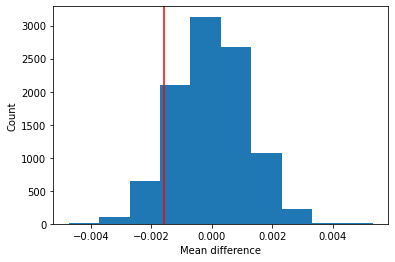

In [27]:
os.makedirs('images', exist_ok=True)
act_diff = df2[df2['group'] == 'treatment']['converted'].mean() -  df2[df2['group'] == 'control']['converted'].mean()
p_diffs = np.array(p_diffs)
plt.axvline(x=act_diff, color='red')
plt.hist(p_diffs)
plt.xlabel('Mean difference')
plt.ylabel('Count')
plt.savefig('images/fig01.jpg', bbox_inches='tight')    
plt.show;

The histogram here follows a normal distribution as expected. According to the Central Limit Theorem, a sample mean or, in this case, the difference of two means, follows a normal distribution given a large enough sample size. In this case 10000 is large enough for the normal distribution to be visible on this histogram.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(act_diff < p_diffs).mean()

0.9063

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

Question 'j' asks to calculate the p-value, which refers to the probability of getting the same or a more extreme value than the one provided by our statistic, assuming the null hypothesis is true. Small p-values suggest the null isn't true, and large p-values suggest the null is true. We compare it to the alpha value (Type 1 error threshold) established at the beginning to determine whether we can reject the null hypothesis or not. In this case, p-value is much larger than 0.05 (alpha), so we fail to reject the null hypothesis.
    
A p-value of 0.9 suggests there's no difference between the new and old pages and if there was any difference it'd be in favor of the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df2.query('group == "control"')['user_id'].count()
n_new = df2.query('group == "treatment"')['user_id'].count()

convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [30]:
count_array = np.array([convert_new, convert_old])
nobs_array = np.array([n_new, n_old])
z_score, p_value = sm.stats.proportions_ztest(count_array, nobs_array, alternative='larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


This source is used for the previous cell:
https://knowledge.udacity.com/questions/768248

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

The following sources are used to answer this question:

https://www.statisticshowto.com/probability-and-statistics/z-score/

https://www.statology.org/z-test-python/

https://www.investopedia.com/terms/z/z-test.asp

The z_test is used to measure how different two population means are (in this case the difference between the converted mean for the new page and the converted mean for the old page).
Since we get a negative value for Z, it indicates the mean difference is negative, so it's suggesting the conversion rate for the old page is higher, similar to the previous tests. The p-value, again a large value, also indicates we fail to reject the null hypothesis, suggesting the old page provides similar converstion rates than the new page.
The p-value is similar to the one calculated before, so these findings agree with the findings from the previous tests in j and k.


<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

Logistic Regression, since we are trying to predict a categorical response with only two possible outcomes.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [31]:
df2['intercept'] = 1
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


In [32]:
df2 = df2.drop('control', axis=1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


In the previous cells, I add the columns for the intercept and the dummy variables for the type of page. Then I delete the one I won't be using (control) and only keep ab_page with the values as indicated in the question.

c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [33]:
logit_mod =sm.Logit(df2['converted'],df2[['intercept', 'ab_page']])
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-03-27 19:28 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

The p-value associated with ab_page is 0.1899. It's smaller than the one calculated before, and from the question itself I assume it's because the null and alternative hypotheses of this regression model are different than the ones used in the previous A/B test.
In a logistic regression model, the hypotheses refer to the relationship between two variables, in this case **X** would be the landing_page, and **Y** would be the conversion result. The null would say there's no relationship, and the alternative that there's a relationship. No relationship means both pages provide similar converted rates, so we could write them as follows:
    
    H0: p_new - p_old = 0
    H1: p_new - p_old != 0
    
    
This is therefore a two-tailed test as opposed to the one-tailed test from the previous section, where we used a 'larger or not' rather than 'equal or not' for the hypotheses.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

The regression model hasn't provided so far a clear understanding on what's making people convert, as the page (old vs new) doesn't seem to be clearly correlated. So it's a good idea to look at other factors to see if we find one with a clear relationship to the conversion rate. However, the more variables we add to the regression model, the higher the chances to find problems like multicollinearity, which we'd have to test for and solve if present.
Another thing to consider would be to run the experiment for a bit longer, as some users of the new page might have previously used the old page and could be resistant to accept the new layout.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives.

Does it appear that country had an impact on conversion? Provide the statistical output as well as a written response to answer this question.

In [35]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [36]:
df_new.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [37]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [38]:
logit_mod2 =sm.Logit(df_new['converted'],df_new[['intercept', 'ab_page', 'UK', 'US']])
results2 = logit_mod2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-03-27 19:28 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
==================================================================

"""

The p-value associated with the countries is still above the alpha of 0.05 and is therefore insufficient to reject the null and assume a relationship.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
### Fit Your Linear Model And Obtain the Results
df_new['page_UK'] = df_new['ab_page'] * df_new['UK']
df_new['page_US'] = df_new['ab_page'] * df_new['US']
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,page_UK,page_US
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [40]:
logit_mod3 =sm.Logit(df_new['converted'],df_new[['intercept', 'ab_page', 'UK', 'US', 'page_UK', 'page_US']])
results3 = logit_mod3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-03-27 19:28 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
page_UK        0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
page_US        0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

We still have p-values higher than the alpha for the interaction variables page_UK and page_US. This means that according to the analyzed data, no interactions took place between the variables country and page visited.

### Conclusions

We haven't found a variable having a clear correlation to the converted rate so far. This suggests we'd still need to keep looking at other potential factors that may impact the converted rate. The dataframe contains information about the date and time when these pages were visited, so that could be another exploration to do. Another option would be to extend the experiment for a longer period of time, since the results might start varying as well.